In [1]:
import warnings

import pandas as pd
import numpy as np

#metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
# Nomralization,standardisation
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#estimators
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
#cross selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings(action="once")

In [3]:
df_train_raw = pd.read_excel('Data/Data_2013-2022.xlsx')

In [4]:
df_test_raw = pd.read_excel('Data/Data_2023.xlsx')

In [5]:
def confusion(y_test, y_pred) : 
    mat = confusion_matrix(y_test, y_pred)
    mat = pd.DataFrame(mat)
    mat.columns = [f"pred_{i}" for i in mat.columns]
    mat.index = [f"test_{i}" for i in mat.index]
    return mat

In [6]:
def score(estimator) :
    tr_score = estimator.score(X_train, y_train).round(4)
    te_score = estimator.score(X_test, y_test).round(4)

    print(f"score train : {tr_score} score test : {te_score} ")
    return te_score

# 1. Data preparation

In [7]:
#Shuffle data
df_train = df_train_raw.sample(frac=1,random_state=1).reset_index(drop=True)

In [8]:
df_train = df_train.drop(columns=["Race","Year"])
df_test = df_test_raw.drop(columns=["Race","Year"])

In [9]:
#Checking correlation between columns
print(df_train.corr()["Breakaway win"].abs().sort_values(ascending=False))

Breakaway win             1.000000
Stage classification      0.409890
elevation gain            0.390591
KM last climb - finish    0.342084
Nbr 2 cat                 0.281083
Nbr 1 cat/HC              0.254558
Nbr 3 cat                 0.210351
Stage nbr                 0.198722
Nbr 4 cat                 0.182892
length                    0.031045
Name: Breakaway win, dtype: float64


In [10]:
X_train = df_train.drop(columns="Breakaway win")
y_train = df_train["Breakaway win"]

In [11]:
X_test = df_test.drop(columns="Breakaway win")
y_test = df_test["Breakaway win"]

In [12]:
scaler = MinMaxScaler() 
#scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

In [13]:
list_score = {}

# 2. Modelisation

## 2.1 Dummy classifier

In [14]:
estimator = DummyClassifier(strategy="most_frequent")
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [15]:
cv_results['test_score']

array([0.62234043, 0.62566845, 0.62032086])

In [16]:
cv_results['test_score'].mean()

0.622776576781583

In [17]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [18]:
sum(test_score) / len(test_score)

0.543859649122807

In [19]:
dum_score = score(estimator)
list_score["Dummy classifier"] = dum_score

score train : 0.6228 score test : 0.5439 


In [20]:
y_pred = estimator.predict(X_test)
dum_pred = estimator.predict(X_test)

In [21]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,31,0
test_1,26,0


In [22]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5

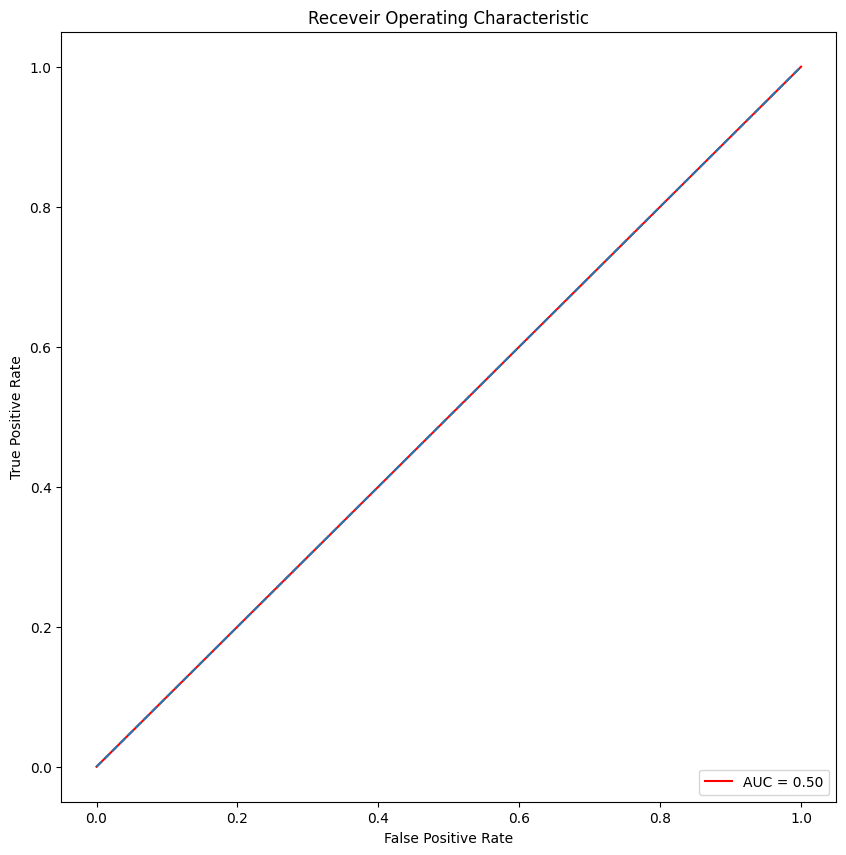

In [23]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.2 Logistic regression

Better result without Normalization

In [24]:
estimator = LogisticRegression(solver="liblinear")
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [25]:
cv_results['test_score']

array([0.68085106, 0.68449198, 0.69518717])

In [26]:
cv_results['test_score'].mean()

0.6868434027382713

In [27]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [28]:
sum(test_score) / len(test_score)

0.6783625730994153

In [29]:
log_score = score(estimator)
list_score["Logistic regression"] = log_score

score train : 0.7117 score test : 0.6667 


In [30]:
y_pred =estimator.predict(X_test)
log_pred = estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [31]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,24,7
test_1,12,14


In [32]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6563275434243175

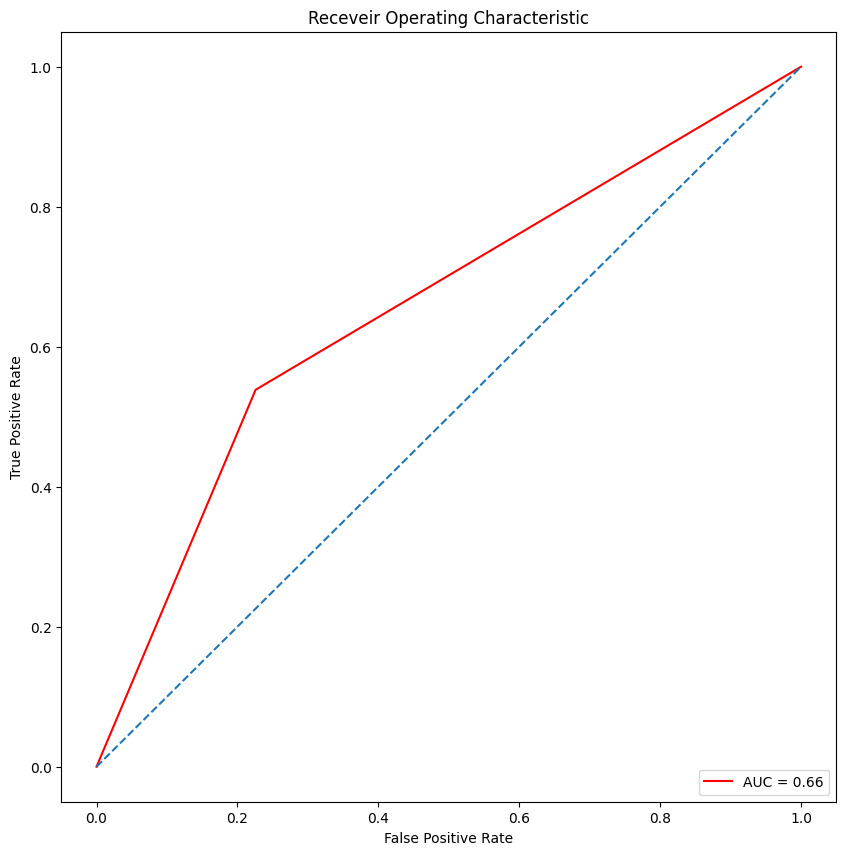

In [33]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

# 2.3 SVM

Better result after Normalization

In [34]:
estimator = LinearSVC(dual=False)

In [35]:
estimator.fit(X_train_norm, y_train)
cv_results = cross_validate(estimator, X_train_norm, y_train, cv=3,return_estimator=True)

In [36]:
cv_results['test_score']

array([0.67021277, 0.70588235, 0.68983957])

In [37]:
cv_results['test_score'].mean()

0.6886448970303789

In [38]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test_norm, y_test))

In [39]:
sum(test_score) / len(test_score)

0.7192982456140351

In [40]:
tr_score = estimator.score(X_train_norm, y_train).round(4)
svm_score = estimator.score(X_test_norm, y_test).round(4)
print(f"score train : {tr_score} score test : {svm_score} ")
list_score["SVM"] = svm_score

score train : 0.7011 score test : 0.7193 


In [41]:
y_pred =estimator.predict(X_test_norm)
svm_pred = estimator.predict(X_test_norm)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [42]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,25,6
test_1,10,16


In [43]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7109181141439206

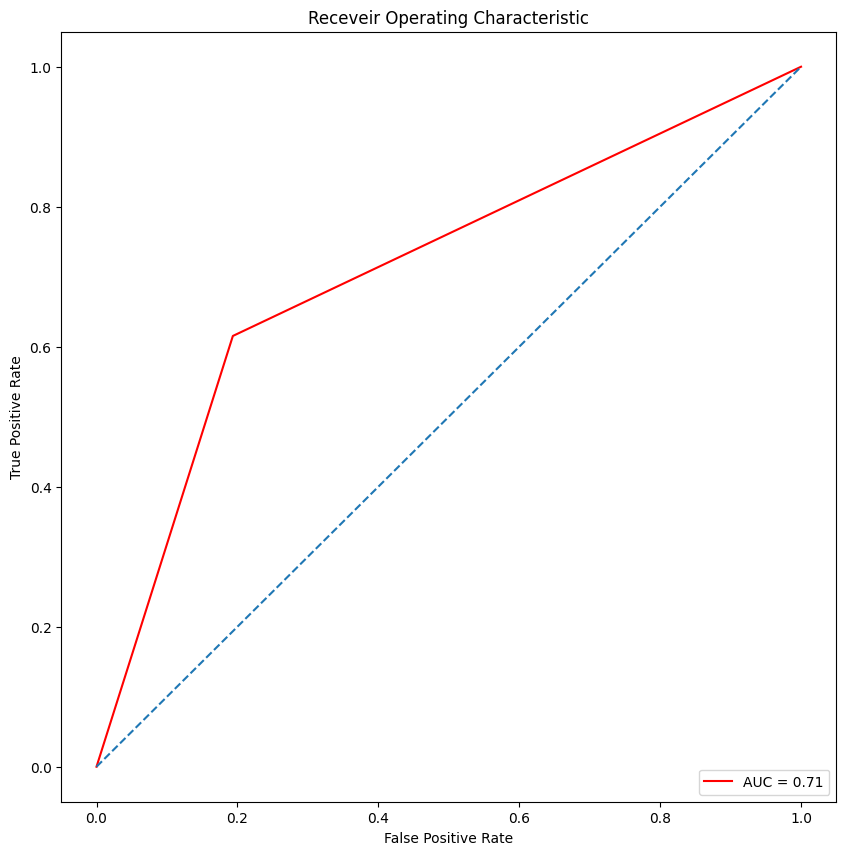

In [44]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.4 Decision trees

Better result without Normalization

In [45]:
estimator = DecisionTreeClassifier()

In [46]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [47]:
cv_results['test_score']

array([0.63297872, 0.62566845, 0.6631016 ])

In [48]:
cv_results['test_score'].mean()

0.6405829256267304

In [49]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [50]:
sum(test_score) / len(test_score)

0.6257309941520467

In [51]:
dt_score = score(estimator)
list_score["Decision trees"] = dt_score

score train : 1.0 score test : 0.6316 


In [52]:
y_pred =estimator.predict(X_test)
dt_pred = estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [53]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,21,10
test_1,11,15


In [54]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6271712158808933

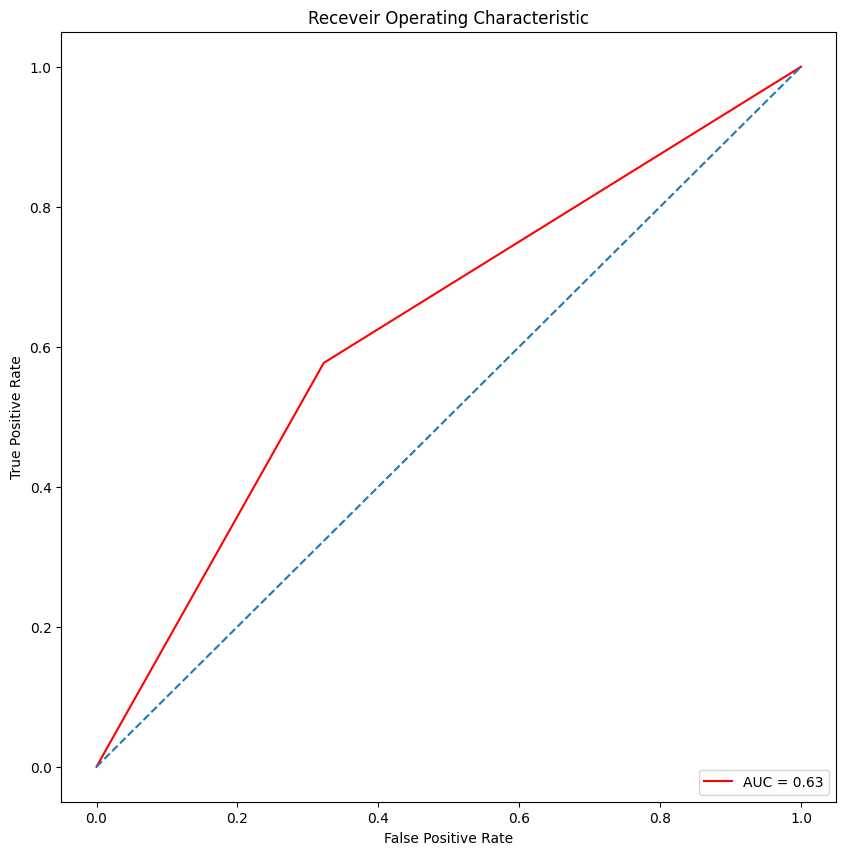

In [55]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.5 Random forest

Better result without Normalization

In [56]:
estimator = RandomForestClassifier()

In [57]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [58]:
cv_results['test_score']

array([0.75      , 0.71657754, 0.70053476])

In [59]:
cv_results['test_score'].mean()

0.7223707664884135

In [60]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [61]:
sum(test_score) / len(test_score)

0.672514619883041

In [62]:
rd_score = score(estimator)
list_score["Random forest"] = rd_score

score train : 1.0 score test : 0.6842 


In [63]:
y_pred =estimator.predict(X_test)
rf_pred = estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [64]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,26,5
test_1,13,13


In [65]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6693548387096774

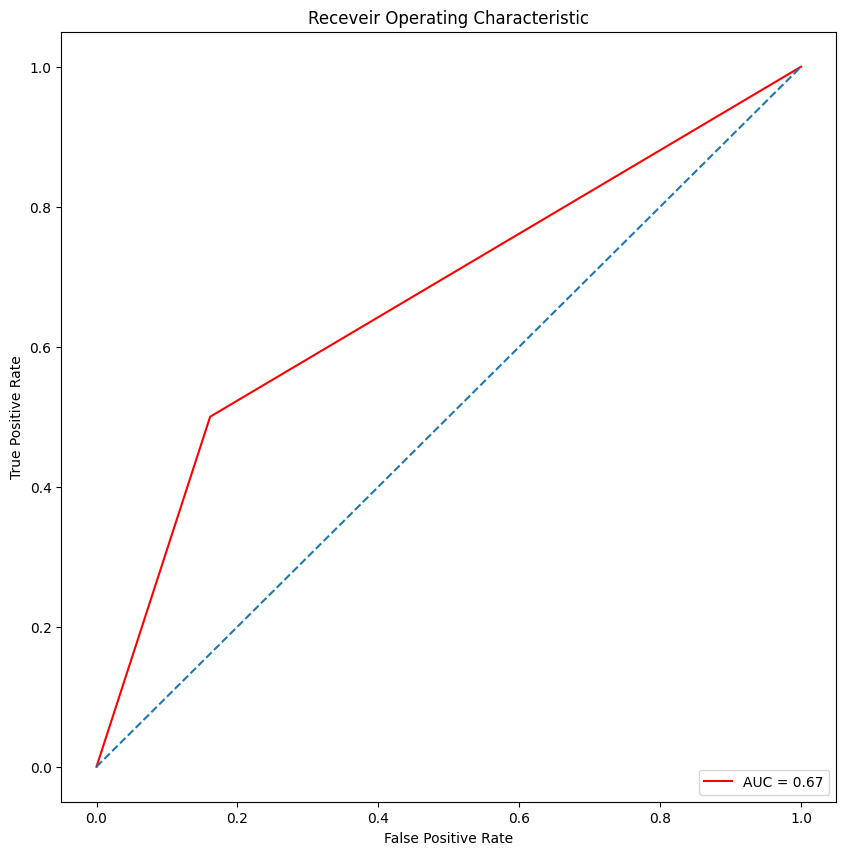

In [66]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.6 Naive Bayes

Better result without Normalization

In [67]:
estimator = GaussianNB()

In [68]:
estimator.fit(X_train, y_train)
cv_results = cross_validate(estimator, X_train, y_train, cv=3,return_estimator=True)

In [69]:
cv_results['test_score']

array([0.71808511, 0.73796791, 0.72727273])

In [70]:
cv_results['test_score'].mean()

0.7277752493647363

In [71]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test, y_test))

In [72]:
sum(test_score) / len(test_score)

0.6959064327485379

In [73]:
nb_score = score(estimator)
list_score["Naive Bayes"] = nb_score

score train : 0.7242 score test : 0.6842 


In [74]:
y_pred =estimator.predict(X_test)
nb_pred = estimator.predict(X_test)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [75]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,21,10
test_1,8,18


In [76]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.684863523573201

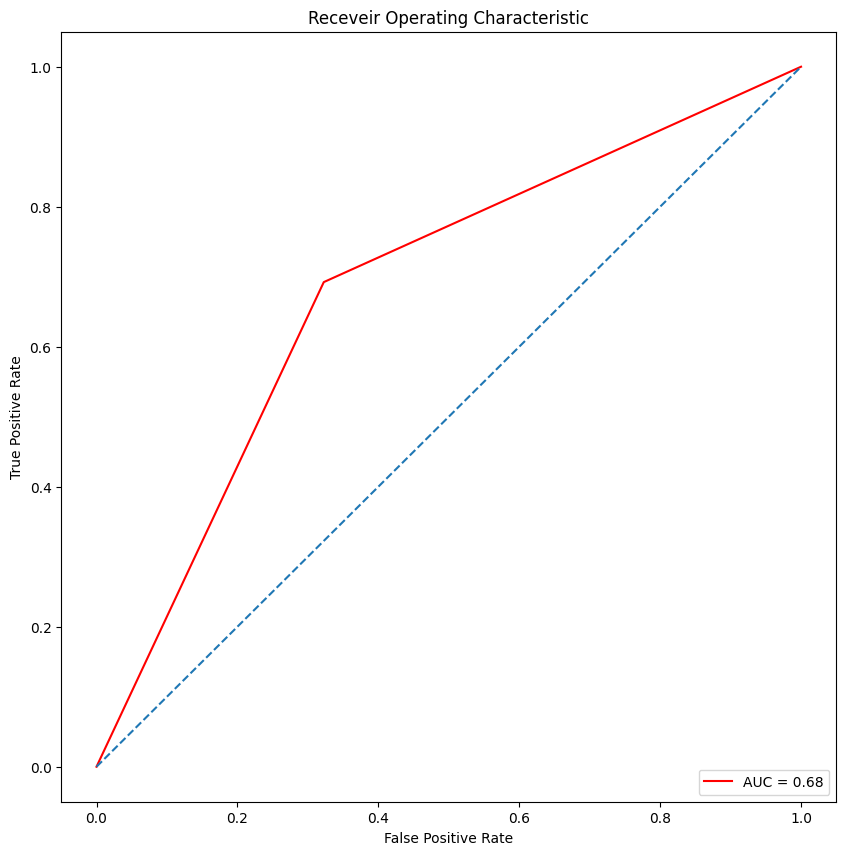

In [77]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## 2.7 K-Nearest Neighbors

Better result after Normalization

In [78]:
estimator = KNeighborsClassifier()

In [79]:
estimator.fit(X_train_norm, y_train)
cv_results = cross_validate(estimator, X_train_norm, y_train, cv=3,return_estimator=True)

In [80]:
cv_results['test_score']

array([0.66489362, 0.73262032, 0.71122995])

In [81]:
cv_results['test_score'].mean()

0.7029146281336519

In [82]:
test_score = []
for i in range(len(cv_results['estimator'])):
  test_score.append(cv_results['estimator'][i].score(X_test_norm, y_test))

In [83]:
sum(test_score) / len(test_score)

0.7251461988304094

In [84]:
tr_score = estimator.score(X_train_norm, y_train).round(4)
knn_score = estimator.score(X_test_norm, y_test).round(4)
print(f"score train : {tr_score} score test : {knn_score} ")
list_score["KNN"] = knn_score

score train : 0.8114 score test : 0.7368 


In [85]:
y_pred =estimator.predict(X_test_norm)
knn_pred = estimator.predict(X_test_norm)
#y_pred = cv_results['estimator'][2].predict(X_test)

In [86]:
confusion(y_test, y_pred)

,pred_0,pred_1
test_0,26,5
test_1,10,16


In [87]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7270471464019852

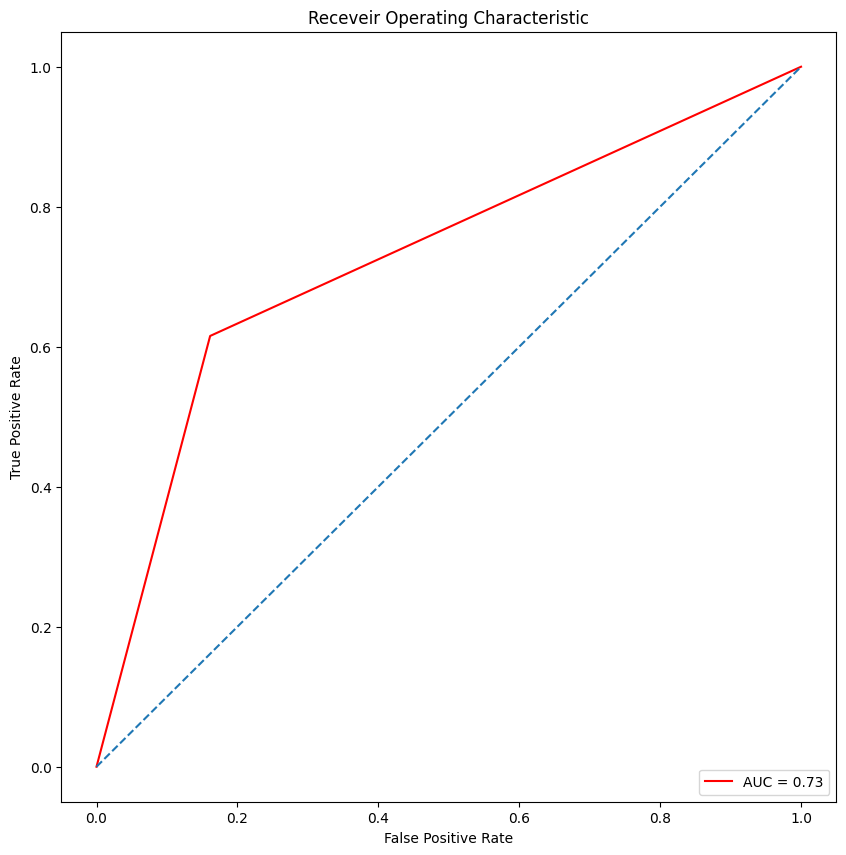

In [88]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

# 3. Overall Result

In [89]:
df_result = pd.DataFrame(list(zip(df_test_raw.iloc[:,0],df_test_raw.iloc[:,2],y_test.astype(int),dum_pred,log_pred,svm_pred,dt_pred,rf_pred,nb_pred,knn_pred)),
                                              columns =["Grand Tour","Stage","Breakaway_win","Dummy pred","Logistic pred","SVM pred","Decision tree pred","Random forest pred","Naive Bayes pred","KNN pred"])

In [90]:
df_result

,Grand Tour,Stage,Breakaway_win,Dummy pred,Logistic pred,SVM pred,Decision tree pred,Random forest pred,Naive Bayes pred,KNN pred
0,Giro,2,0,0,0,0,0,0,0,0
1,Giro,3,0,0,0,0,0,0,0,0
2,Giro,4,1,0,0,1,1,1,1,1
3,Giro,5,0,0,0,0,0,0,0,0
4,Giro,6,0,0,0,0,0,0,0,0
5,Giro,7,1,0,1,1,0,0,1,0
6,Giro,8,1,0,0,0,0,1,0,0
7,Giro,10,1,0,0,0,1,0,0,1
8,Giro,11,0,0,0,0,0,0,0,0
9,Giro,12,1,0,0,1,1,1,1,1


list_score = list(list_score.items())

In [91]:
score_df = pd.DataFrame(list_score.items())
score_df.sort_values(by=[1],ascending=False,inplace=True)
score_df

,0,1
6,KNN,0.7368
2,SVM,0.7193
4,Random forest,0.6842
5,Naive Bayes,0.6842
1,Logistic regression,0.6667
3,Decision trees,0.6316
0,Dummy classifier,0.5439


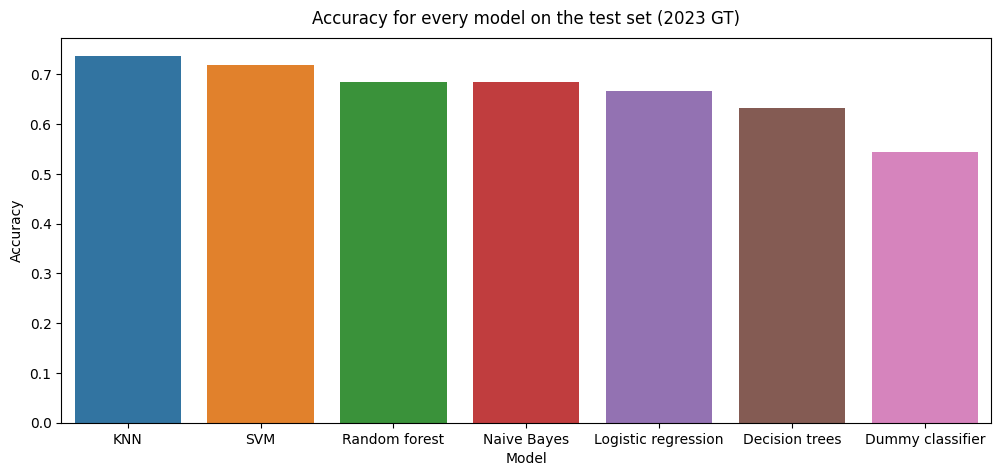

In [92]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=0, y =1, data = score_df)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title("Accuracy for every model on the test set (2023 GT)", pad = 10);
 

# 4. Optimizing best algo

Considering the result score, KNN seems to give the best result on the test data (Without Vuelta for now), let's see if we can improve this score by tuning the algo

In [93]:
#Here is a reminds of the KNN score before tuning
tr_score = estimator.score(X_train_norm, y_train).round(4)
knn_score = estimator.score(X_test_norm, y_test).round(4)
print(f"score train : {tr_score} score test : {knn_score} ")

score train : 0.8114 score test : 0.7368 


## 4.1 Find best k (number of neighbors) 

In [94]:
# calculating the score of models with different values of k
mean_score = np.zeros(20)
mean_tr_score = np.zeros(20)
for i in range(1,21):
    #Train Model and Predict  
    knn = KNeighborsClassifier(n_neighbors = i).fit(X_train_norm,y_train)
    mean_score[i-1] = knn.score(X_test_norm, y_test).round(4)
    mean_tr_score[i-1] = knn.score(X_train_norm, y_train).round(4)
    

print(mean_score)
print(mean_tr_score)

[0.6491 0.6491 0.7193 0.6667 0.7368 0.7193 0.7368 0.7018 0.7544 0.7193
 0.7368 0.7193 0.7719 0.7719 0.7895 0.7719 0.7719 0.7544 0.7544 0.7018]
[1.     0.8505 0.8345 0.806  0.8114 0.7936 0.7865 0.8007 0.7918 0.774
 0.774  0.7669 0.7633 0.7633 0.7651 0.7669 0.7562 0.7633 0.742  0.7491]


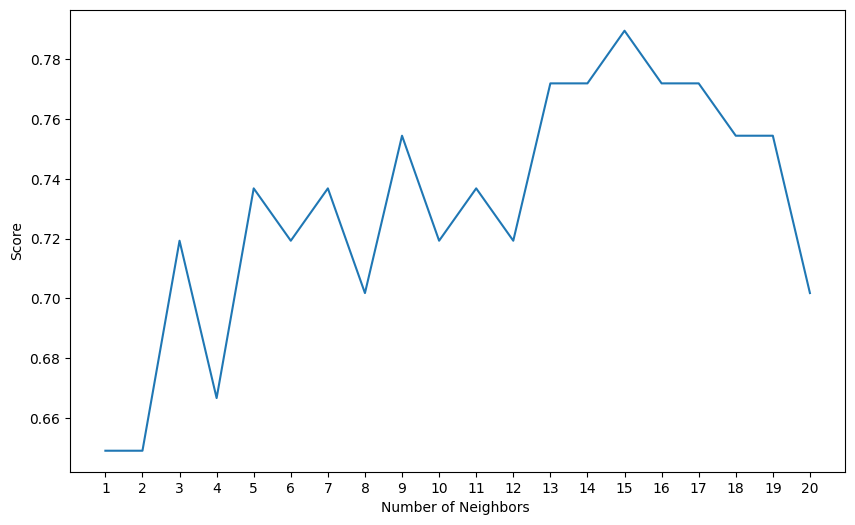

In [95]:
loc = np.arange(1,21,step=1.0)
plt.figure(figsize = (10, 6))
plt.plot(range(1,21), mean_score)
plt.xticks(loc)
plt.xlabel('Number of Neighbors ')
plt.ylabel('Score')
plt.show()

The best values are [13,15,17,19]

## 4.2 Hyperparameter Tuning

In [96]:
#We will use the Exhaustive Grid Search technique
grid_params = { 'n_neighbors' : [13,15,17,19],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

In [97]:
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=3, n_jobs = -1)
g_res = gs.fit(X_train_norm, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [98]:
# find the best score
g_res.best_score_

0.7420070542723859

In [99]:
# get the hyperparameters with the best score
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}

## 4.3 Evaluate the model after tuning

In [100]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 19, weights = 'distance',algorithm = 'brute',metric = 'manhattan')
knn.fit(X_train_norm, y_train)

KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=19,
                     weights='distance')

In [101]:
tr_score = knn.score(X_train_norm, y_train).round(4)
knn_score_tuned = knn.score(X_test_norm, y_test).round(4)

print(f"score train : {tr_score} score test : {knn_score} ")
list_score["KNN TUNED"] = knn_score_tuned

score train : 1.0 score test : 0.7368 


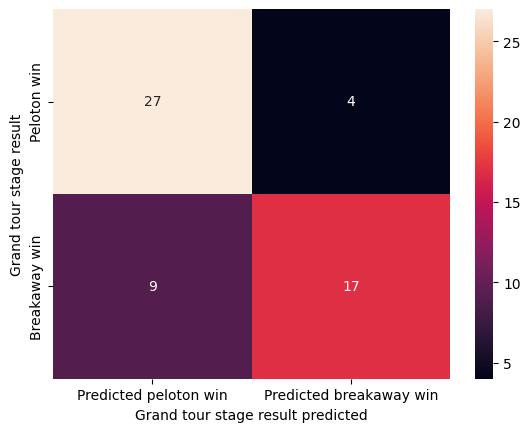

In [112]:
y_pred =knn.predict(X_test_norm)
knn_opti_pred = knn.predict(X_test_norm)
conf = confusion(y_test, y_pred)
ax = sns.heatmap(conf, annot = conf,xticklabels = ["Predicted peloton win","Predicted breakaway win"],yticklabels =["Peloton win","Breakaway win"] )  
ax.set(xlabel="Grand tour stage result predicted", ylabel="Grand tour stage result")
plt.show()

In [107]:
conf

,pred_0,pred_1
test_0,27,4
test_1,9,17


In [ ]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Receveir Operating Characteristic")
plt.plot(false_positive_rate,true_positive_rate, color="red", label= "AUC = %0.2f" % roc_auc)
plt.legend(loc = "lower right")
plt.plot([0,1],[0,1], linestyle="--")
plt.axis("tight")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [ ]:
df_result = pd.DataFrame(list(zip(df_test_raw.iloc[:,0],df_test_raw.iloc[:,2],y_test.astype(int),knn_pred,knn_opti_pred)),
                                              columns =["Grand Tour","Stage","Breakaway_win","KNN pred","KNN opti pred"])

In [ ]:
score_df_full = pd.DataFrame(list_score.items())
score_df_full.sort_values(by=[1],ascending=False,inplace=True)

fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=0, y =1, data = score_df_full)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title("Accuracy for every model on the test set (2023 GT)", pad = 10);
 